## Load Dataset

In [ ]:
import pyodbc
import mysql.connector
import dask.dataframe as dd
import pandas as pd
# from scripts.db_utils import create_ebay_connection
import os 
from dotenv import load_dotenv

load_dotenv()

def create_ebay_connection():
    """Create connection to the hosted SQL Server database for IP addresses."""
    try:
        connection = pyodbc.connect(
            f"DRIVER={{MySQL ODBC 9.1 Unicode Driver}};"
            f"SERVER={os.getenv('EBAY_DB_HOST')};"
            f"DATABASE={os.getenv('EBAY_DB_NAME')};"
            f"UID={os.getenv('EBAY_DB_USER')};"
            f"PWD={os.getenv('EBAY_DB_PASSWORD')}"
        )
        return connection
    except pyodbc.Error as e:
        print(f"Error connecting to hosted database: {e}")
        return None
# Database connection parameters
conn = create_ebay_connection()

query = "SELECT * FROM tbl_iptrace_user_activity where ams_trans_rsn_cd=0"


def fetch_data_in_chunks(conn, query, chunk_size=100000):
    """
    Fetch data from the database in chunks, then convert to Dask DataFrame.
    """
    offset = 0
    while True:
        # Modify the query to include pagination using LIMIT and OFFSET for chunks
        paginated_query = f"{query} LIMIT {chunk_size} OFFSET {offset}"
        
        # Fetch data in chunks using pandas (it handles column and row alignment internally)
        df_chunk = pd.read_sql_query(paginated_query, conn)
        
        if df_chunk.empty:
            break
        
        # Convert to Dask DataFrame
        dask_df = dd.from_pandas(df_chunk, npartitions=4)
        
        yield dask_df
        
        offset += chunk_size


dask_chunks = []

# Fetch chunks and store them in the list
for dask_df_chunk in fetch_data_in_chunks(conn, query, chunk_size=100000):
    dask_chunks.append(dask_df_chunk)

# Concatenate all chunks into a single Dask DataFrame
full_dask_df = dd.concat(dask_chunks)


# Show the result
print(full_dask_df.head())


In [ ]:
# full_dask_df = full_dask_df.drop(columns=['id', 'ams_trans_rsn_cd', 'is_vpn'])
full_dask_df.tail()


In [ ]:
unique_count = full_dask_df['click_id'].nunique().compute()

# Display the result
print(f"Unique value count in 'click_id': {unique_count}")


In [ ]:
print('no. of rows :', full_dask_df.shape[0].compute())

## Prepare test(300k rows) and train(100k rows) data

In [ ]:
import dask.dataframe as dd

# Convert the Dask DataFrame to Pandas DataFrame
full_df_pandas = full_dask_df.compute().reset_index(drop=True)

# Sample 300k rows for the training set using Pandas
train_df_pandas = full_df_pandas.sample(n=300000, random_state=42)

# Remove the sampled rows for training set from the original DataFrame to get the remaining rows
remaining_df_pandas = full_df_pandas[~full_df_pandas.index.isin(train_df_pandas.index)]

# Sample 100k rows for the testing set from the remaining rows
test_df_pandas = remaining_df_pandas.sample(n=100000, random_state=42)

# Check the sizes of the sampled DataFrames
train_size = train_df_pandas.shape[0]
test_size = test_df_pandas.shape[0]

print(f"Training set size: {train_size}")
print(f"Testing set size: {test_size}")


In [45]:
train_df_pandas.to_csv('../data/csv/train_set.csv', index=False)
test_df_pandas.to_csv('../data/csv/test_set.csv', index=False)


## Load train dataset and implement preprocessing

In [1]:
import pandas as pd

df = pd.read_csv('../data/csv/data.csv')

In [2]:
print(df.shape)
df.head()

(1254243, 6)


,CLNT_RMT_IP,ROI_CLICK_EVENT_TS,BRWSR_NAME,ams_pblshr_id,buyer_id,click_id
0,77.111.247.168,2020-08-02 18:37:01,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,valen_949,209245484389035777
1,66.249.73.101,2020-08-21 03:36:38,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586
2,77.111.247.129,2020-08-21 03:36:38,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586
3,66.249.73.101,2020-08-21 03:36:33,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586
4,77.111.247.129,2020-08-21 03:36:33,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586


In [5]:
from user_agents import parse
import pandas as pd
import swifter  # for parallel processing with Pandas (install with `pip install swifter`)

# Dictionary to cache parsed user-agent strings and reduce redundant parsing
user_agent_cache = {}

def extract_user_agent_features_optimized(ua_string):
    # Check if this user-agent string has already been parsed
    if ua_string in user_agent_cache:
        return user_agent_cache[ua_string]
    
    # Parse the user agent string and store parsed results in a variable
    user_agent = parse(ua_string)
    
    # Extract required features
    result = {
        'browser': user_agent.browser.family,
        # 'browser_version': user_agent.browser.version_string,
        'os': user_agent.os.family,
        # 'os_version': user_agent.os.version_string,
        'device_type': (
    'mobile' if user_agent.is_mobile else
    'desktop' if user_agent.is_pc else
    'tablet' if user_agent.is_tablet else
    'bot' if user_agent.is_bot else 'other'
        )
    }
    
    # Store result in the cache
    user_agent_cache[ua_string] = result
    
    return result

# Apply optimized function to the user-agent column with parallel processing using swifter
df_user_agent_features = df['BRWSR_NAME'].swifter.apply(extract_user_agent_features_optimized).apply(pd.Series)
df = pd.concat([df, df_user_agent_features], axis=1)
df = df.drop('BRWSR_NAME', axis=1)
def categorize_browser(browser_column):
    # Define the browsers to keep based on the 10,000 row threshold
    popular_browsers = ['Chrome Mobile', 'Chrome', 'Mobile Safari', 'Mobile Safari UI/WKWebView', 'Edge', 'Firefox', 'Samsung Internet', 'Safari', 'Google', 'Chrome Mobile', 'Opera', 'FacebookBot', 'Facebook', 'ImagesiftBot']

    # Apply the categorization
    browser_column = browser_column.apply(lambda x: x if x in popular_browsers else 'Other')
    return browser_column

# Function to categorize OS based on the 1% rule and keeping till Ubuntu
def categorize_os(os_column):
    # Define the OSes to keep based on the row threshold (up to Ubuntu)
    popular_os = ['Android', 'Other', 'iOS', 'Windows', 'Mac OS X', 'Linux', 'Ubuntu', 'Chrome OS']

    # Apply the categorization
    os_column = os_column.apply(lambda x: x if x in popular_os else 'Other')
    return os_column

# Apply categorization functions to the DataFrame
df['browser'] = categorize_browser(df['browser'])
df['os'] = categorize_os(df['os'])

# Display the transformed DataFrame
print(df)

Pandas Apply:   0%|          | 0/1254243 [00:00<?, ?it/s]

             CLNT_RMT_IP   ROI_CLICK_EVENT_TS  ams_pblshr_id      buyer_id  \
0         77.111.247.168  2020-08-02 18:37:01     5574672411     valen_949   
1          66.249.73.101  2020-08-21 03:36:38     5574672411    morbanisaf   
2         77.111.247.129  2020-08-21 03:36:38     5574672411    morbanisaf   
3          66.249.73.101  2020-08-21 03:36:33     5574672411    morbanisaf   
4         77.111.247.129  2020-08-21 03:36:33     5574672411    morbanisaf   
...                  ...                  ...            ...           ...   
1254238   172.226.114.69  2024-09-05 11:04:49     5575612316         srw38   
1254239  208.115.224.233  2024-09-29 06:41:18     5575532731  katzenklo_16   
1254240   138.199.29.213  2024-10-09 03:15:37     5575319207      guyver13   
1254241  172.225.240.192  2024-10-27 03:30:27     5575376664    winde_-129   
1254242   172.226.114.83  2024-11-03 04:57:09     5575791307     monika_pl   

                   click_id                     browser       o

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(20, 6))
sns.countplot(x='browser', data=df)
plt.title('Bar Plot of browser')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='os', data=df)
plt.title('Bar Plot of os')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='device_type', data=df)
plt.title('Bar Plot of device_type')
plt.show()



In [3]:
import re

# Function to check if the IP address is valid
def is_valid_ipv4(ip):
    if pd.isna(ip):  # Check for None or NaN
        return False
    pattern = r'^(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.(25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)$'
    return re.match(pattern, ip) is not None

# Apply the function and create a mask for valid IP addresses
valid_ips_mask = df['CLNT_RMT_IP'].apply(is_valid_ipv4)

# Drop rows with invalid IP addresses
df = df[valid_ips_mask]

import socket
import struct
from sklearn.preprocessing import OneHotEncoder


# 1. Convert IP to integer
def ipv4_to_int(ip):
    return struct.unpack("!I", socket.inet_aton(ip))[0]

df['ip_as_int'] = df['CLNT_RMT_IP'].apply(ipv4_to_int)
df['ROI_CLICK_EVENT_TS'] = pd.to_datetime(df['ROI_CLICK_EVENT_TS'])


# 3. Extract features from datetime
df['year'] = df['ROI_CLICK_EVENT_TS'].dt.year
df['month'] = df['ROI_CLICK_EVENT_TS'].dt.month
df['day'] = df['ROI_CLICK_EVENT_TS'].dt.day
df['hour'] = df['ROI_CLICK_EVENT_TS'].dt.hour
df['minute'] = df['ROI_CLICK_EVENT_TS'].dt.minute
df['second'] = df['ROI_CLICK_EVENT_TS'].dt.second
df['day_of_week'] = df['ROI_CLICK_EVENT_TS'].dt.dayofweek  # Monday=0, Sunday=6

# 4. Drop original date and time columns
# df.drop(['CLNT_RMT_IP', 'CLICK_TS'], axis=1, inplace=True)


In [4]:
df.shape

(1254243, 14)

In [5]:
df.head()

,CLNT_RMT_IP,ROI_CLICK_EVENT_TS,BRWSR_NAME,ams_pblshr_id,buyer_id,click_id,ip_as_int,year,month,day,hour,minute,second,day_of_week
0,77.111.247.168,2020-08-02 18:37:01,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,valen_949,209245484389035777,1299183528,2020,8,2,18,37,1,6
1,66.249.73.101,2020-08-21 03:36:38,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586,1123633509,2020,8,21,3,36,38,4
2,77.111.247.129,2020-08-21 03:36:38,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586,1299183489,2020,8,21,3,36,38,4
3,66.249.73.101,2020-08-21 03:36:33,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586,1123633509,2020,8,21,3,36,33,4
4,77.111.247.129,2020-08-21 03:36:33,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586,1299183489,2020,8,21,3,36,33,4


In [8]:
# import numpy as np
# def generate_features(df):
#     # 1. Aggregation by different categorical combinations
    
#     # Clicks per Publisher-Buyer
#     clicks_per_publisher_buyer = df.groupby(['ams_pblshr_id', 'buyer_id']).agg(
#         clicks_per_publisher_buyer=('click_id', 'count'),
#         avg_click_time_per_publisher_buyer=('hour', 'mean'),
#         clicks_per_hour_per_publisher_buyer=('hour', 'count'),
#         unique_ip_addresses_per_publisher_buyer=('ip_as_int', 'nunique'),
#         days_since_last_click_per_publisher_buyer=('day', lambda x: x.max() - x.min())
#     ).reset_index()
#     clicks_per_publisher_buyer.columns = [f'publisher_buyer_{col}' for col in clicks_per_publisher_buyer.columns]
    
#     # Clicks per Buyer-Click ID
#     clicks_per_buyer_click_id = df.groupby(['buyer_id', 'click_id']).agg(
#         clicks_per_buyer_click_id=('click_id', 'count'),
#         avg_time_between_clicks_per_buyer_click_id=('minute', lambda x: np.mean(np.diff(sorted(x)))),
#         unique_publishers_per_buyer_click_id=('ams_pblshr_id', 'nunique'),
#         clicks_per_device_type_per_buyer_click_id=('device_type', 'count')
#     ).reset_index()
#     clicks_per_buyer_click_id.columns = [f'buyer_click_id_{col}' for col in clicks_per_buyer_click_id.columns]
    
#     # Clicks per Publisher-Browser
#     clicks_per_publisher_browser = df.groupby(['ams_pblshr_id', 'browser']).agg(
#         clicks_per_publisher_browser=('click_id', 'count'),
#         avg_click_time_per_publisher_browser=('hour', 'mean'),
#         clicks_per_ip_per_publisher_browser=('ip_as_int', 'count'),
#         unique_buyers_per_publisher_browser=('buyer_id', 'nunique')
#     ).reset_index()
#     clicks_per_publisher_browser.columns = [f'publisher_browser_{col}' for col in clicks_per_publisher_browser.columns]
    
#     # Clicks per OS-Device Type
#     clicks_per_os_device_type = df.groupby(['os', 'device_type']).agg(
#         clicks_per_os_device_type=('click_id', 'count'),
#         clicks_per_hour_per_os_device_type=('hour', 'count'),
#         clicks_per_day_of_week_per_os_device_type=('day_of_week', 'count'),
#         unique_buyers_per_os_device_type=('buyer_id', 'nunique')
#     ).reset_index()
#     clicks_per_os_device_type.columns = [f'os_device_type_{col}' for col in clicks_per_os_device_type.columns]
    
#     # Clicks per Buyer-Device Type
#     clicks_per_buyer_device_type = df.groupby(['buyer_id', 'device_type']).agg(
#         clicks_per_buyer_device_type=('click_id', 'count'),
#         avg_click_time_per_buyer_device_type=('hour', 'mean'),
#         clicks_per_browser_per_buyer_device_type=('browser', 'count')
#     ).reset_index()
#     clicks_per_buyer_device_type.columns = [f'buyer_device_type_{col}' for col in clicks_per_buyer_device_type.columns]
    
#     # Clicks per IP-Browser
#     clicks_per_ip_browser = df.groupby(['ip_as_int', 'browser']).agg(
#         clicks_per_ip_browser=('click_id', 'count'),
#         avg_time_between_clicks_per_ip_browser=('minute', lambda x: np.mean(np.diff(sorted(x)))),
#         unique_buyers_per_ip_browser=('buyer_id', 'nunique')
#     ).reset_index()
#     clicks_per_ip_browser.columns = [f'ip_browser_{col}' for col in clicks_per_ip_browser.columns]
    
#     # Clicks per IP-Device Type
#     clicks_per_ip_device_type = df.groupby(['ip_as_int', 'device_type']).agg(
#         clicks_per_ip_device_type=('click_id', 'count'),
#         clicks_per_device_type_per_ip=('device_type', 'count')
#     ).reset_index()
#     clicks_per_ip_device_type.columns = [f'ip_device_type_{col}' for col in clicks_per_ip_device_type.columns]
    
#     # Clicks per Browser-OS
#     clicks_per_browser_os = df.groupby(['browser', 'os']).agg(
#         clicks_per_browser_os=('click_id', 'count'),
#         avg_time_between_clicks_per_browser_os=('minute', lambda x: np.mean(np.diff(sorted(x)))),
#         unique_buyers_per_browser_os=('buyer_id', 'nunique')
#     ).reset_index()
#     clicks_per_browser_os.columns = [f'browser_os_{col}' for col in clicks_per_browser_os.columns]
    
#     # Clicks per IP-Device Type-OS
#     clicks_per_ip_device_os = df.groupby(['ip_as_int', 'device_type', 'os']).agg(
#         clicks_per_ip_device_os=('click_id', 'count'),
#         avg_time_between_clicks_per_ip_device_os=('minute', lambda x: np.mean(np.diff(sorted(x)))),
#         unique_buyers_per_ip_device_os=('buyer_id', 'nunique')
#     ).reset_index()
#     clicks_per_ip_device_os.columns = [f'ip_device_os_{col}' for col in clicks_per_ip_device_os.columns]
    
#     # Combine all features into a single DataFrame
#     features_df = pd.concat([
#         clicks_per_publisher_buyer,
#         clicks_per_buyer_click_id,
#         clicks_per_publisher_browser,
#         clicks_per_os_device_type,
#         clicks_per_buyer_device_type,
#         clicks_per_ip_browser,
#         clicks_per_ip_device_type,
#         clicks_per_browser_os,
#         clicks_per_ip_device_os
#     ], axis=1)

#     return features_df

# # Generate features
# feature_df = generate_features(df)

# # Display the resulting features
# print(feature_df.head())


c:\Users\ramegupta\OneDrive - eBay Inc\Desktop\Utkarsh\vpn-annotator\vpn_annotator\env\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ramegupta\OneDrive - eBay Inc\Desktop\Utkarsh\vpn-annotator\vpn_annotator\env\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


c:\Users\ramegupta\OneDrive - eBay Inc\Desktop\Utkarsh\vpn-annotator\vpn_annotator\env\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ramegupta\OneDrive - eBay Inc\Desktop\Utkarsh\vpn-annotator\vpn_annotator\env\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ramegupta\OneDrive - eBay Inc\Desktop\Utkarsh\vpn-annotator\vpn_annotator\env\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ramegupta\OneDrive - eBay Inc\Desktop\Utkarsh\vpn-annotator\vpn_annotator\env\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\ramegupta\OneDrive - eBay Inc\Desktop\Utkarsh\vpn-annotator\vpn_annotator\env\L

   publisher_buyer_ams_pblshr_id publisher_buyer_buyer_id  \
0                   5.574628e+09            cushmanyblatz   
1                   5.574628e+09                   hbming   
2                   5.574628e+09              jenricoshea   
3                   5.574628e+09         rvanbilliard0276   
4                   5.574628e+09                 sbradc55   

   publisher_buyer_clicks_per_publisher_buyer  \
0                                         3.0   
1                                         1.0   
2                                         1.0   
3                                         1.0   
4                                         3.0   

   publisher_buyer_avg_click_time_per_publisher_buyer  \
0                                          18.333333    
1                                          14.000000    
2                                          10.000000    
3                                           5.000000    
4                                           9.666667 

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.cluster import KMeans
# from sklearn.impute import SimpleImputer

# # Step 1: Select only numeric columns (int and float)
# numeric_columns = feature_df.select_dtypes(include=['int64', 'float64'])

# # Step 2: Impute missing values with the mean of the column
# imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or 'most_frequent'
# numeric_columns_imputed = imputer.fit_transform(numeric_columns)

# # Step 3: Convert the imputed numeric data back to DataFrame and retain column names
# numeric_columns_imputed = pd.DataFrame(numeric_columns_imputed, columns=numeric_columns.columns)

# # Step 4: Standardize the numeric features
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(numeric_columns_imputed)

# # Step 5: Apply KMeans for clustering
# kmeans = KMeans(n_clusters=2)  # Specify number of clusters
# kmeans_labels = kmeans.fit_predict(scaled_features)
# numeric_columns_imputed['fraud_cluster'] = kmeans_labels

# # Step 6: Mark fraud (cluster outliers) based on the cluster label
# numeric_columns_imputed['is_fraud'] = numeric_columns_imputed['fraud_cluster'].apply(lambda x: 1 if x == 1 else 0)

# # Step 7: Combine the features dataframe with the original dataframe
# # Ensure we're only combining with the rows that were imputed (those that match numeric_columns_imputed)
# df_with_features = df.loc[numeric_columns_imputed.index]  # This ensures indices match
# df_with_features = pd.concat([df_with_features, numeric_columns_imputed], axis=1)

# # Step 8: Display the results
# print(df_with_features.head())  # Display first few rows

# # Step 9: Visualize the clustering result using PCA
# pca = PCA(n_components=2)
# reduced_features = pca.fit_transform(scaled_features)

# # Add PCA components to the dataframe for visualization
# df_with_features['pca1'] = reduced_features[:, 0]
# df_with_features['pca2'] = reduced_features[:, 1]

# # Plot the results
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=df_with_features, x='pca1', y='pca2', hue='fraud_cluster', palette='Set1', s=60, alpha=0.7)
# plt.title('Click Clusters and Fraud (Outliers)')
# plt.show()


In [6]:
import pandas as pd
from itertools import combinations
from sklearn.preprocessing import StandardScaler



# Step 1: Generate all possible combinations of 'CLNT_RMT_IP', 'ams_pblshr_id', 'buyer_id'
columns = ['CLNT_RMT_IP', 'ams_pblshr_id', 'buyer_id']
combinations_list = []

# Add single column combinations
for i in range(1, len(columns) + 1):
    combinations_list.extend(combinations(columns, i))

# Step 2: Group by each combination and get the count of 'click_id'
result_list = []
for comb in combinations_list:
    grouped = df.groupby(list(comb)).size().reset_index(name=f'click_count_{"+".join(comb)}')
    result_list.append(grouped)
print(len(result_list))

# Step 3: Merge all grouped results back into the original dataframe
merged_df = df.copy()
for result in result_list:
    merged_df = pd.merge(merged_df, result, how='left', on=list(result.columns[:-1]))  # Exclude 'click_count'

# Step 4: Handle missing values (if any) and fill them with 0 or another appropriate value
merged_df.fillna(0, inplace=True)

click_count_columns = [col for col in merged_df.columns if col.startswith('click_count')]

# Step 6: Apply scaling to the 'click_count' columns
scaler = StandardScaler()
merged_df[click_count_columns] = scaler.fit_transform(merged_df[click_count_columns])

# Output the final DataFrame with scaled features
print("DataFrame with Scaled Click Count Features:")
print(merged_df)


7
DataFrame with Scaled Click Count Features:
             CLNT_RMT_IP  ROI_CLICK_EVENT_TS  \
0         77.111.247.168 2020-08-02 18:37:01   
1          66.249.73.101 2020-08-21 03:36:38   
2         77.111.247.129 2020-08-21 03:36:38   
3          66.249.73.101 2020-08-21 03:36:33   
4         77.111.247.129 2020-08-21 03:36:33   
...                  ...                 ...   
1254238   172.226.114.69 2024-09-05 11:04:49   
1254239  208.115.224.233 2024-09-29 06:41:18   
1254240   138.199.29.213 2024-10-09 03:15:37   
1254241  172.225.240.192 2024-10-27 03:30:27   
1254242   172.226.114.83 2024-11-03 04:57:09   

                                                BRWSR_NAME  ams_pblshr_id  \
0        Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5574672411   
1        Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5574672411   
2        Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5574672411   
3        Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     557467

In [7]:
merged_df.head()

,CLNT_RMT_IP,ROI_CLICK_EVENT_TS,BRWSR_NAME,ams_pblshr_id,buyer_id,click_id,ip_as_int,year,month,day,...,minute,second,day_of_week,click_count_CLNT_RMT_IP,click_count_ams_pblshr_id,click_count_buyer_id,click_count_CLNT_RMT_IP+ams_pblshr_id,click_count_CLNT_RMT_IP+buyer_id,click_count_ams_pblshr_id+buyer_id,click_count_CLNT_RMT_IP+ams_pblshr_id+buyer_id
0,77.111.247.168,2020-08-02 18:37:01,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,valen_949,209245484389035777,1299183528,2020,8,2,...,37,1,6,0.094327,2.08812,-0.218090,0.183951,-0.198287,-0.203267,-0.186461
1,66.249.73.101,2020-08-21 03:36:38,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586,1123633509,2020,8,21,...,36,38,4,-0.438712,2.08812,-0.214557,-0.267096,-0.197360,-0.199484,-0.185466
2,77.111.247.129,2020-08-21 03:36:38,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586,1299183489,2020,8,21,...,36,38,4,0.090485,2.08812,-0.214557,0.188008,-0.197360,-0.199484,-0.185466
3,66.249.73.101,2020-08-21 03:36:33,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586,1123633509,2020,8,21,...,36,33,4,-0.438712,2.08812,-0.214557,-0.267096,-0.197360,-0.199484,-0.185466
4,77.111.247.129,2020-08-21 03:36:33,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,5574672411,morbanisaf,209453736892211586,1299183489,2020,8,21,...,36,33,4,0.090485,2.08812,-0.214557,0.188008,-0.197360,-0.199484,-0.185466


In [13]:
categorical_features = ['browser', 'os', 'device_type']
df_encoded = pd.get_dummies(merged_df, columns=categorical_features)
df_encoded.head()


,CLNT_RMT_IP,ROI_CLICK_EVENT_TS,ams_pblshr_id,buyer_id,click_id,ip_as_int,year,month,day,hour,...,os_Linux,os_Mac OS X,os_Other,os_Ubuntu,os_Windows,os_iOS,device_type_desktop,device_type_mobile,device_type_other,device_type_tablet
0,77.111.247.168,2020-08-02 18:37:01,5574672411,valen_949,209245484389035777,1299183528,2020,8,2,18,...,False,False,False,False,True,False,True,False,False,False
1,66.249.73.101,2020-08-21 03:36:38,5574672411,morbanisaf,209453736892211586,1123633509,2020,8,21,3,...,False,False,False,False,True,False,True,False,False,False
2,77.111.247.129,2020-08-21 03:36:38,5574672411,morbanisaf,209453736892211586,1299183489,2020,8,21,3,...,False,False,False,False,True,False,True,False,False,False
3,66.249.73.101,2020-08-21 03:36:33,5574672411,morbanisaf,209453736892211586,1123633509,2020,8,21,3,...,False,False,False,False,True,False,True,False,False,False
4,77.111.247.129,2020-08-21 03:36:33,5574672411,morbanisaf,209453736892211586,1299183489,2020,8,21,3,...,False,False,False,False,True,False,True,False,False,False


In [8]:
merged_df.columns

Index(['CLNT_RMT_IP', 'ROI_CLICK_EVENT_TS', 'BRWSR_NAME', 'ams_pblshr_id',
       'buyer_id', 'click_id', 'ip_as_int', 'year', 'month', 'day', 'hour',
       'minute', 'second', 'day_of_week', 'click_count_CLNT_RMT_IP',
       'click_count_ams_pblshr_id', 'click_count_buyer_id',
       'click_count_CLNT_RMT_IP+ams_pblshr_id',
       'click_count_CLNT_RMT_IP+buyer_id',
       'click_count_ams_pblshr_id+buyer_id',
       'click_count_CLNT_RMT_IP+ams_pblshr_id+buyer_id'],
      dtype='object')

## PCA

Explained variance ratio by each component: [7.61726758e-01 1.56438664e-01 6.35214289e-02 9.36154362e-03
 5.37476287e-03 3.50543752e-03 7.14046161e-05]
Cumulative explained variance: [0.76172676 0.91816542 0.98168685 0.99104839 0.99642316 0.9999286
 1.        ]
Number of components to retain for 90.0% variance: 2


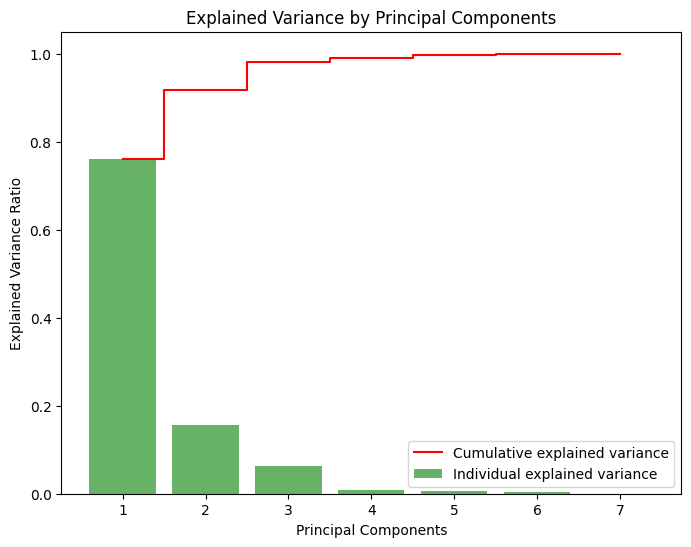

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

cols = ['click_count_CLNT_RMT_IP',
       'click_count_ams_pblshr_id', 'click_count_buyer_id',
       'click_count_CLNT_RMT_IP+ams_pblshr_id',
       'click_count_CLNT_RMT_IP+buyer_id',
       'click_count_ams_pblshr_id+buyer_id',
       'click_count_CLNT_RMT_IP+ams_pblshr_id+buyer_id']

# 1. Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df)
X_scaled = merged_df[cols]
# 2. Apply PCA
pca = PCA(n_components=None)  # Use all components
X_pca = pca.fit_transform(X_scaled)

# 3. Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio by each component:", explained_variance)

# Cumulative explained variance to decide how many components to retain
cumulative_variance = explained_variance.cumsum()
print("Cumulative explained variance:", cumulative_variance)

# If you want to decide how many components to keep
threshold = 0.90  # For example, keep enough components to explain 90% of the variance
n_components_to_keep = (cumulative_variance >= threshold).argmax() + 1
print(f"Number of components to retain for {threshold*100}% variance:", n_components_to_keep)

# Visualize the explained variance
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, color='g', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance', color='r')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend(loc='best')
plt.show()


      CLNT_RMT_IP  ROI_CLICK_EVENT_TS  \
0  77.111.247.168 2020-08-02 18:37:01   
1   66.249.73.101 2020-08-21 03:36:38   
2  77.111.247.129 2020-08-21 03:36:38   
3   66.249.73.101 2020-08-21 03:36:33   
4  77.111.247.129 2020-08-21 03:36:33   

                                          BRWSR_NAME  ams_pblshr_id  \
0  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5574672411   
1  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5574672411   
2  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5574672411   
3  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5574672411   
4  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5574672411   

     buyer_id            click_id   ip_as_int  year  month  day  ...  \
0   valen_949  209245484389035777  1299183528  2020      8    2  ...   
1  morbanisaf  209453736892211586  1123633509  2020      8   21  ...   
2  morbanisaf  209453736892211586  1299183489  2020      8   21  ...   
3  morbanisaf  209453736892211586  112

d:\vpn_annotator\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


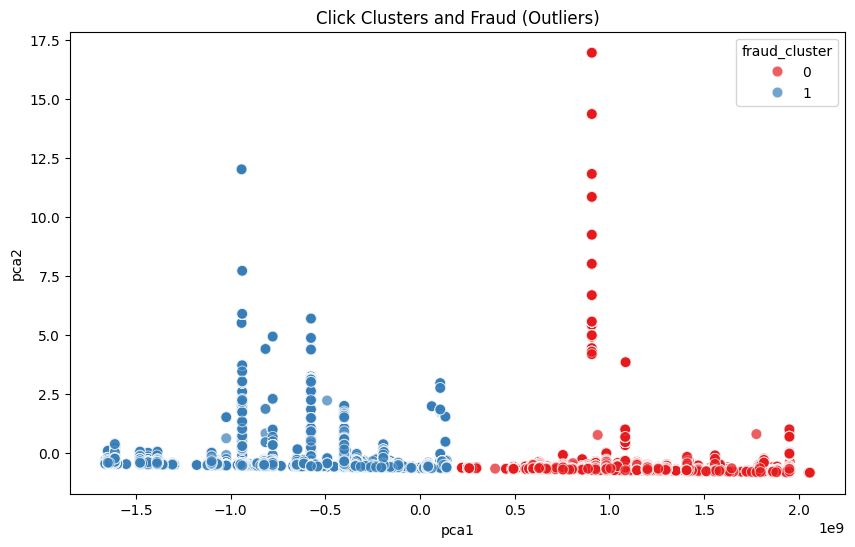

In [ ]:


# 'device_type_desktop', 'device_type_mobile',
#        'device_type_other', 'device_type_tablet'
# 'browser_Chrome',
#        'browser_Chrome Mobile', 'browser_Edge', 'browser_Facebook',
#        'browser_Firefox', 'browser_Google', 'browser_Mobile Safari',
#        'browser_Mobile Safari UI/WKWebView', 'browser_Opera', 'browser_Other',
#        'browser_Safari', 'browser_Samsung Internet', 'os_Android',
#        'os_Chrome OS', 'os_Linux', 'os_Mac OS X', 'os_Other', 'os_Ubuntu',
#        'os_Windows', 'os_iOS'
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Step 1: Select only numeric columns (int and float)
numeric_columns = feature_df.select_dtypes(include=['int64', 'float64'])

# Step 2: Impute missing values with the mean of the column
imputer = SimpleImputer(strategy='mean')  # You can also use 'median' or 'most_frequent'
numeric_columns_imputed = imputer.fit_transform(numeric_columns)

# Step 3: Convert the imputed numeric data back to DataFrame and retain column names
numeric_columns_imputed = pd.DataFrame(numeric_columns_imputed, columns=numeric_columns.columns)

# Step 4: Standardize the numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_columns_imputed)

# Step 5: Apply KMeans for clustering
kmeans = KMeans(n_clusters=2)  # Specify number of clusters
kmeans_labels = kmeans.fit_predict(numeric_columns_imputed)
numeric_columns_imputed['fraud_cluster'] = kmeans_labels

# Step 6: Mark fraud (cluster outliers) based on the cluster label
numeric_columns_imputed['is_fraud'] = numeric_columns_imputed['fraud_cluster'].apply(lambda x: 1 if x == 1 else 0)

# Step 7: Combine the features dataframe with the original dataframe
# Ensure we're only combining with the rows that were imputed (those that match numeric_columns_imputed)
df_with_features = df.loc[numeric_columns_imputed.index]  # This ensures indices match
df_with_features = pd.concat([df_with_features, numeric_columns_imputed], axis=1)

# Step 8: Display the results
# print(df_with_features.head())  # Display first few rows

# Step 9: Visualize the clustering result using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(numeric_columns_imputed)

# Add PCA components to the dataframe for visualization
df_with_features['pca1'] = reduced_features[:, 0]
df_with_features['pca2'] = reduced_features[:, 1]

# Plot the results
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_with_features, x='pca1', y='pca2', hue='fraud_cluster', palette='Set1', s=60, alpha=0.7)
plt.title('Click Clusters and Fraud (Outliers)')
plt.show()


## LOF

      CLNT_RMT_IP  ROI_CLICK_EVENT_TS  \
0  77.111.247.168 2020-08-02 18:37:01   
1   66.249.73.101 2020-08-21 03:36:38   
2  77.111.247.129 2020-08-21 03:36:38   
3   66.249.73.101 2020-08-21 03:36:33   
4  77.111.247.129 2020-08-21 03:36:33   

                                          BRWSR_NAME  ams_pblshr_id  \
0  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5574672411   
1  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5574672411   
2  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5574672411   
3  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5574672411   
4  Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...     5574672411   

     buyer_id            click_id   ip_as_int  year  month  day  ...  \
0   valen_949  209245484389035777  1299183528  2020      8    2  ...   
1  morbanisaf  209453736892211586  1123633509  2020      8   21  ...   
2  morbanisaf  209453736892211586  1299183489  2020      8   21  ...   
3  morbanisaf  209453736892211586  112

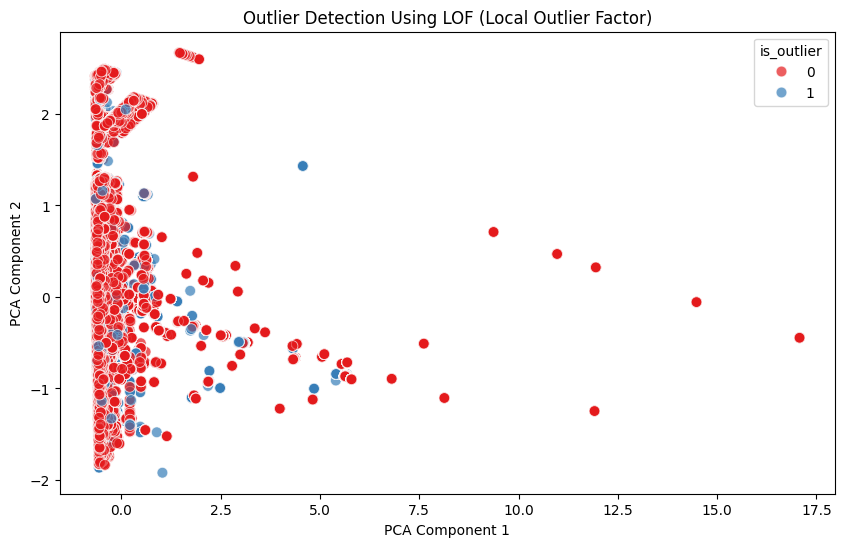

In [14]:
cols = ['ip_as_int', 'year', 'month', 'day', 'hour', 'minute',
       'second', 'day_of_week', 'click_count_CLNT_RMT_IP',
       'click_count_ams_pblshr_id', 'click_count_buyer_id',
       'click_count_CLNT_RMT_IP+ams_pblshr_id',
       'click_count_CLNT_RMT_IP+buyer_id',
       'click_count_ams_pblshr_id+buyer_id',
       'click_count_CLNT_RMT_IP+ams_pblshr_id+buyer_id', ]
# feature_df = df_encoded[cols]
feature_df = merged_df[cols]

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Step 1: Select only numeric columns
numeric_columns = feature_df.select_dtypes(include=['int64', 'float64'])

# Step 2: Impute missing values with the mean of each column
imputer = SimpleImputer(strategy='mean')
numeric_columns_imputed = imputer.fit_transform(numeric_columns)

# Step 3: Convert the imputed data back to DataFrame with original column names
numeric_columns_imputed = pd.DataFrame(numeric_columns_imputed, columns=numeric_columns.columns)

# Step 4: Standardize the numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_columns_imputed)

# Step 5: Apply Local Outlier Factor (LOF) for outlier detection
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Adjust contamination as needed
lof_labels = lof.fit_predict(scaled_features)

# LOF labels are -1 for outliers and 1 for inliers, convert to binary outlier flag
numeric_columns_imputed['is_outlier'] = (lof_labels == -1).astype(int)

df_with_features = df.loc[numeric_columns_imputed.index]  # Ensure the indices match
df_with_features = pd.concat([df_with_features, numeric_columns_imputed], axis=1)

# Step 7: Display the results (first few rows)
print(df_with_features.head())

# Step 8: Visualize the outliers using PCA for dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Add PCA components to the dataframe for visualization
df_with_features['pca1'] = reduced_features[:, 0]
df_with_features['pca2'] = reduced_features[:, 1]

# Step 9: Plot the results showing outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_with_features, x='pca1', y='pca2', hue='is_outlier', palette='Set1', s=60, alpha=0.7)
plt.title('Outlier Detection Using LOF (Local Outlier Factor)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [13]:
# df_with_features.to_csv('../data/csv/click_fraud_results.csv', index=False)
# df_with_features.to_csv('../data/csv/click_fraud_results_lof.csv', index=False)

df_with_features.columns

Index(['ip_as_int', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'day_of_week', 'click_count_CLNT_RMT_IP', 'click_count_ams_pblshr_id',
       'click_count_buyer_id', 'click_count_CLNT_RMT_IP+ams_pblshr_id',
       'click_count_CLNT_RMT_IP+buyer_id',
       'click_count_ams_pblshr_id+buyer_id',
       'click_count_CLNT_RMT_IP+ams_pblshr_id+buyer_id', 'is_outlier', 'pca1',
       'pca2'],
      dtype='object')

In [15]:
selected_columns = ['CLNT_RMT_IP',  'ROI_CLICK_EVENT_TS', 'ams_pblshr_id', 'buyer_id',  
                    'is_outlier']

# Create a new DataFrame with only the selected columns
selected_df = df_with_features[selected_columns]

# Export this DataFrame to a CSV file
selected_df.to_csv('../data/csv/click_fraud_results_lof.csv', index=False)


## Analyse the anamolous buyers

In [21]:
import pandas as pd

df = pd.read_csv('../data/csv/click_fraud_results_no_ua.csv')
# anomaly_buyers = ['timhu_11', 'ndeals100', 'ndeals60', 'ndeals80', 'ndeals90', 'supenko2', 'alphaseeker']
# anomaly_buyers_df = df[df['buyer_id'].isin(anomaly_buyers)]
sampled_df = df.sample(n=200000)
sampled_df.to_csv('../data/csv/sampled.csv', index= False)
# values_where_A_is_0 = df[df['is_fraud'] == 0]['CLNT_RMT_IP']
'../data/csv/click_fraud_results_no_ua.csv'
# print(len(values_where_A_is_0))



'../data/csv/click_fraud_results_no_ua.csv'

In [ ]:
# values_set = set(values_where_A_is_0)

# # Convert the set to a list
# values_list = list(values_set)
# len(values_list)


3878

In [3]:
anomaly_buyers_df['is_fraud'].unique()

array([0, 1])

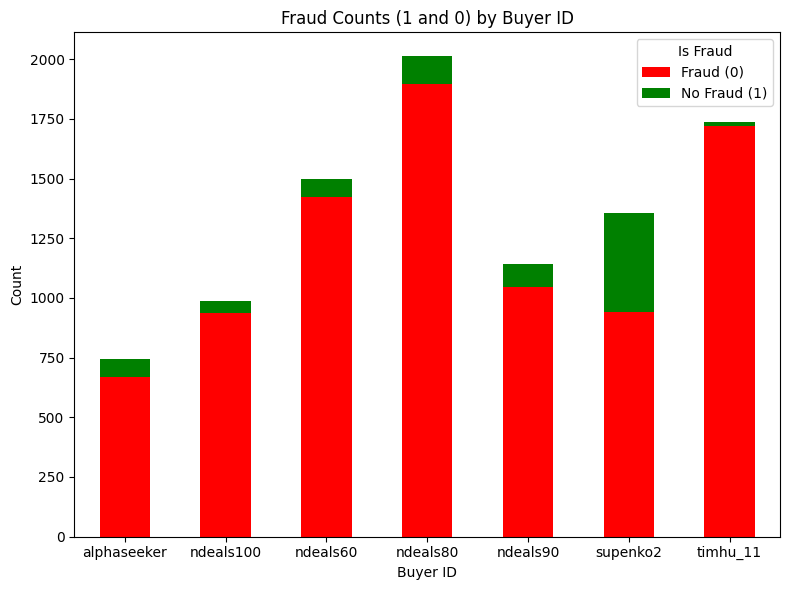

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fraud_counts = anomaly_buyers_df.groupby('buyer_id')['is_fraud'].value_counts().unstack(fill_value=0)

# Plotting
fraud_counts.plot(kind='bar', stacked=True, color=['red', 'green'], figsize=(8, 6))

# Adding titles and labels
plt.title('Fraud Counts (1 and 0) by Buyer ID')
plt.xlabel('Buyer ID')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title='Is Fraud', labels=['Fraud (0)', 'No Fraud (1)'])

# Show the plot
plt.tight_layout()
plt.show()


In [5]:
ip_count = anomaly_buyers_df.groupby('buyer_id')['CLNT_RMT_IP'].nunique()

# Display the result
print(ip_count)


buyer_id
alphaseeker    17
ndeals100      14
ndeals60       36
ndeals80       35
ndeals90       10
supenko2       20
timhu_11       11
Name: CLNT_RMT_IP, dtype: int64


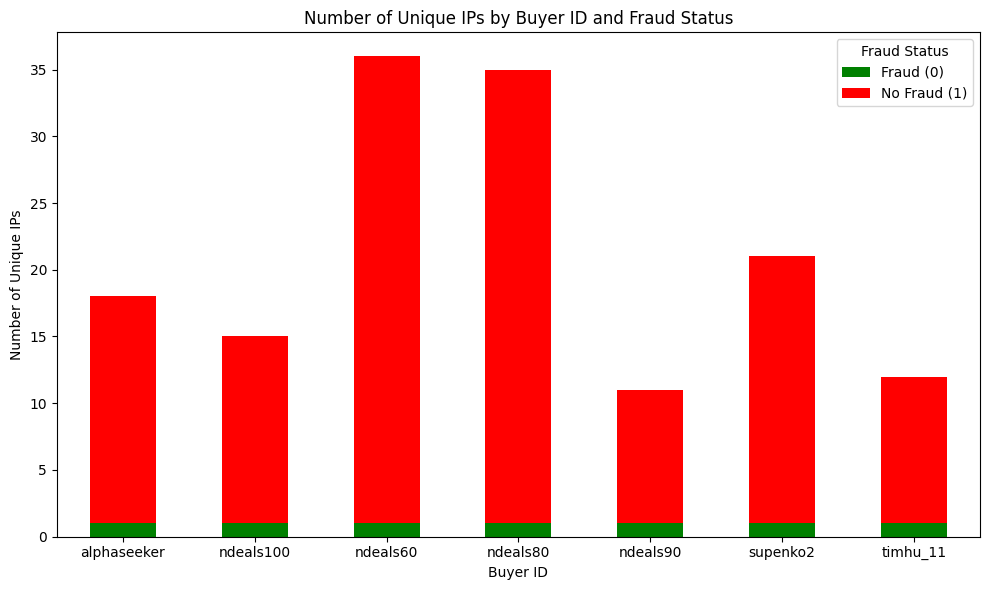

In [6]:
ip_count_by_fraud = anomaly_buyers_df.groupby(['buyer_id', 'is_fraud'])['CLNT_RMT_IP'].nunique().unstack(fill_value=0)

# Plotting
ip_count_by_fraud.plot(kind='bar', stacked=True, figsize=(10, 6), color=['green', 'red'])

# Adding titles and labels
plt.title('Number of Unique IPs by Buyer ID and Fraud Status')
plt.xlabel('Buyer ID')
plt.ylabel('Number of Unique IPs')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title='Fraud Status', labels=['Fraud (0)', 'No Fraud (1)'])

# Show the plot
plt.tight_layout()
plt.show()


In [7]:
# ip_count_by_fraud

NameError: name 'ip_count_by_fraud' is not defined

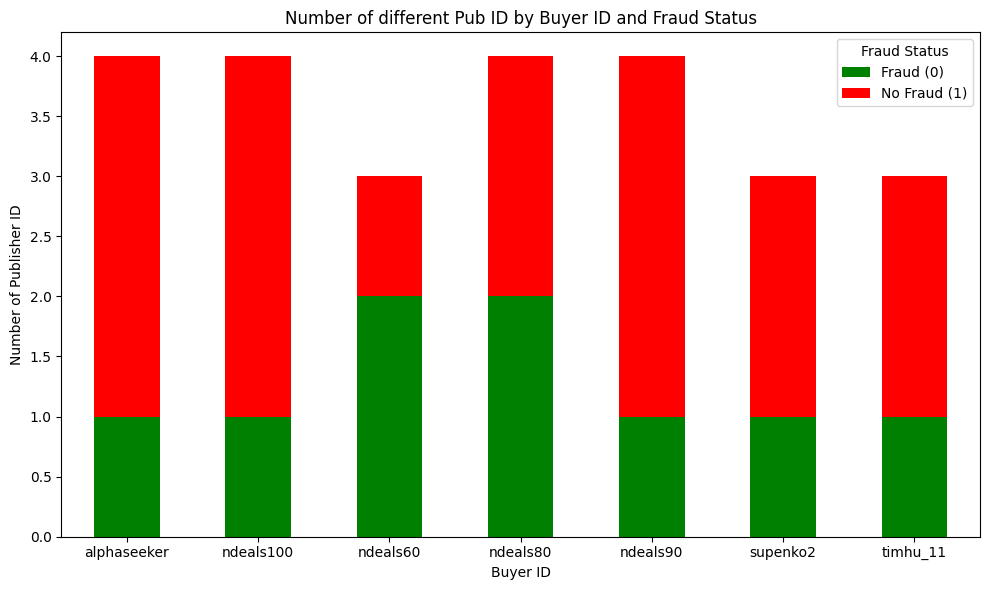

In [7]:
ip_count_by_fraud = anomaly_buyers_df.groupby(['buyer_id', 'is_fraud'])['ams_pblshr_id'].nunique().unstack(fill_value=0)

# Plotting
ip_count_by_fraud.plot(kind='bar', stacked=True, figsize=(10, 6), color=['green', 'red'])

# Adding titles and labels
plt.title('Number of different Pub ID by Buyer ID and Fraud Status')
plt.xlabel('Buyer ID')
plt.ylabel('Number of Publisher ID')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.legend(title='Fraud Status', labels=['Fraud (0)', 'No Fraud (1)'])

# Show the plot
plt.tight_layout()
plt.show()


In [8]:
anomaly_buyers_df['ROI_CLICK_EVENT_TS']= pd.to_datetime(anomaly_buyers_df['ROI_CLICK_EVENT_TS'])
# anomaly_buyers
# buyer_time_series = anomaly_buyers_df.groupby(['buyer_id', 'ROI_CLICK_EVENT_TS']).size().unstack(fill_value=0)
# import seaborn as sns

# # Extract the date from the timestamp (we'll group by this date)
# anomaly_buyers_df['date'] = anomaly_buyers_df['ROI_CLICK_EVENT_TS'].dt.date

# # Group by 'buyer_id' and 'date', then count occurrences for each buyer on each day
# anomaly_buyers_df = anomaly_buyers_df['ROI_CLICK_EVENT_TS'] >= pd.to_datetime('2023-10-01')

# buyer_daywise = anomaly_buyers_df.groupby(['buyer_id', 'date']).size().unstack(fill_value=0)

# # Plotting the time series for each buyer_id
# plt.figure(figsize=(20,6))

# # Define a color palette, one color for each buyer
# buyer_colors = sns.color_palette("tab10", n_colors=len(buyer_daywise))

# # Plot each buyer_id's occurrences over time as a line (time series)
# for idx, buyer_id in enumerate(buyer_daywise.index):
#     plt.plot(buyer_daywise.columns, buyer_daywise.loc[buyer_id], label=f'Buyer {buyer_id}', color=buyer_colors[idx], marker='o', linestyle='-')

# # Adding titles and labels
# plt.title('Buyer Occurrences Day-wise (Time Series)')
# plt.xlabel('Date')
# plt.ylabel('Occurrences')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
# plt.legend(title='Buyer ID')

# # Show the plot
# plt.tight_layout()
# plt.show()


C:\Users\ramegupta\AppData\Local\Temp\ipykernel_21284\2916667229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly_buyers_df['ROI_CLICK_EVENT_TS']= pd.to_datetime(anomaly_buyers_df['ROI_CLICK_EVENT_TS'])


C:\Users\ramegupta\AppData\Local\Temp\ipykernel_21284\2163812480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly_buyers_df['month'] = anomaly_buyers_df['ROI_CLICK_EVENT_TS'].dt.to_period('M')  # Aggregating by month


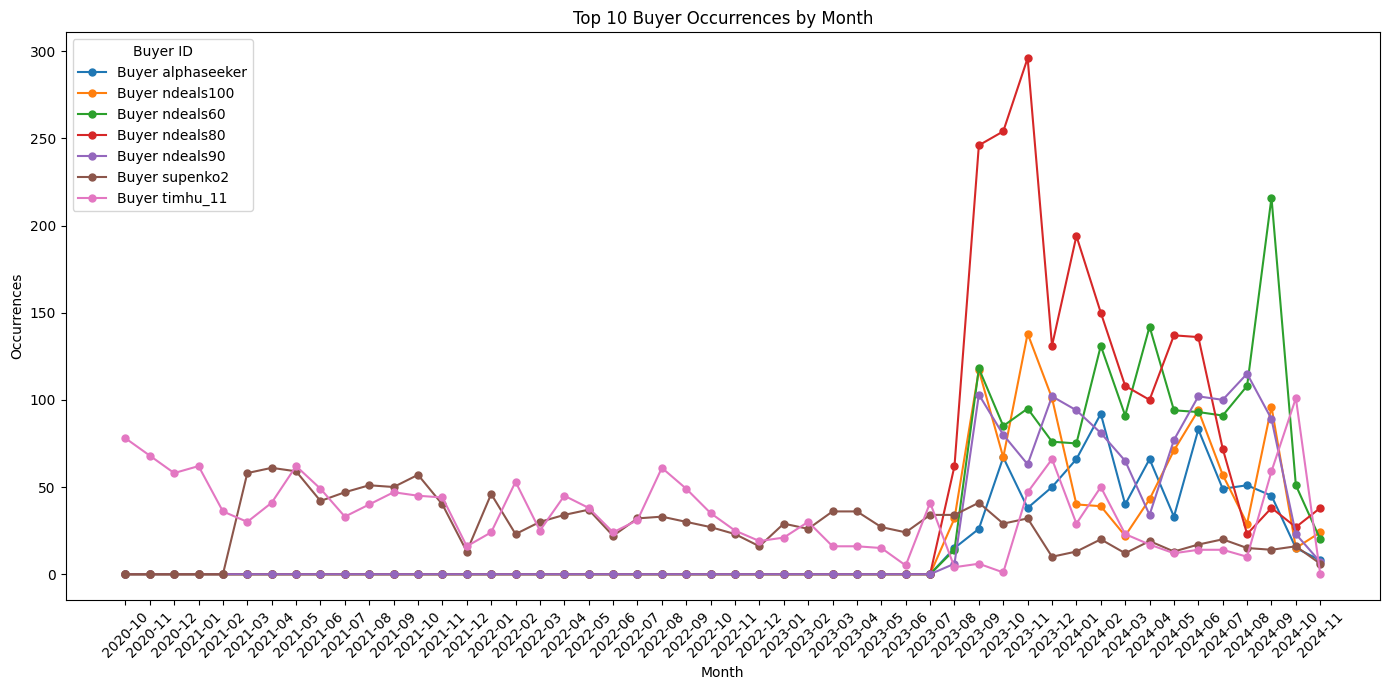

In [9]:
anomaly_buyers_df['month'] = anomaly_buyers_df['ROI_CLICK_EVENT_TS'].dt.to_period('M')  # Aggregating by month

# Group by 'buyer_id' and 'month', then count occurrences
buyer_monthwise = anomaly_buyers_df.groupby(['buyer_id', 'month']).size().unstack(fill_value=0)

# Plotting the time series for each buyer_id (month-wise in this case)
plt.figure(figsize=(14, 7))  # Larger figure size

# Define a color palette, one color for each buyer
buyer_colors = sns.color_palette("tab10", n_colors=len(buyer_monthwise))

# Plot each buyer_id's occurrences over time as a line (time series)
for idx, buyer_id in enumerate(buyer_monthwise.index):
    plt.plot(buyer_monthwise.columns.astype(str), buyer_monthwise.loc[buyer_id], 
             label=f'Buyer {buyer_id}', color=buyer_colors[idx], marker='o', linestyle='-', markersize=5)

# Adding titles and labels
plt.title('Top 10 Buyer Occurrences by Month')
plt.xlabel('Month')
plt.ylabel('Occurrences')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title='Buyer ID')

# Show the plot
plt.tight_layout()
plt.show()


In [27]:
anomaly_buyers_df

26        False
53        False
106        True
138       False
198       False
          ...  
299827     True
299894     True
299962     True
299990    False
299996    False
Name: ROI_CLICK_EVENT_TS, Length: 9471, dtype: bool